# 0. Importing Necessary Packages

In [1]:
# Printing the information of Python, IPython, OS, and the generation date.
%load_ext version_information
%version_information

Software versions
Python 3.7.9 64bit [GCC 7.3.0]
IPython 7.16.1
OS Linux 5.8.18 100.fc31.x86_64 x86_64 with fedora 31 Thirty_One
Tue Mar 22 18:34:05 2022 KST

In [2]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'scipy', 'matplotlib', 'astropy']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.21.0
scipy: ver 1.6.2
matplotlib: ver 3.2.2
astropy: ver 4.2.1


In [3]:
# matplotlib backend
%matplotlib notebook

# importing necessary modules
import numpy as np
import glob, os
from matplotlib import pyplot as plt
from astropy.io import fits

# 1. Inspecting the Data

In [4]:
current_dir = os.path.abspath(".")
raw_dir = current_dir+"/NGC3367/0_raw/"
bias_list = sorted(glob.glob(raw_dir+"cal*bias.fit"))
dark_list = sorted(glob.glob(raw_dir+"cal*dk*.fit"))
flat_list = sorted(glob.glob(raw_dir+"skyflat*.fit"))
sci_list  = sorted(glob.glob(raw_dir+"NGC3367*.fit"))
print(f"Bias: {len(bias_list):d} frames")
print(f"Dark: {len(dark_list):d} frames")
print(f"Flat (sky): {len(flat_list):d} frames")
print(f"Science (object): {len(sci_list):d} frames")

Bias: 9 frames
Dark: 27 frames
Flat (sky): 7 frames
Science (object): 6 frames


In [5]:
fits.open(sci_list[0]).info()

Filename: /data/jlee/DATA/TA/2022A/Class1/NGC3367/0_raw/NGC3367-0001R.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      45   (3192, 2129)   int16 (rescales to uint16)   


In [6]:
data, hdr = fits.getdata(sci_list[0], header=True)
hdr

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 3192 /fastest changing axis                           
NAXIS2  =                 2129 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2022-03-20T13:52:47' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   120.00000000000000 /Exposure time in seconds                        
EXPOSURE=   120.00000000000000 /Exposure time in seconds                        
SET-TEMP=  -20.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -20.014793395996094 /CCD temperature at start of exposure in C       
XPIXSZ  =   11.2799999999999

In [7]:
for keys in ['DATE-OBS', 'EXPTIME', 'FILTER', 'INSTRUME']:
    print(keys+" = "+str(hdr[keys]))

DATE-OBS = 2022-03-20T13:52:47
EXPTIME = 120.0
FILTER = R
INSTRUME = Moravian Instruments, C3-61000EC PRO


<IPython.core.display.Javascript object>


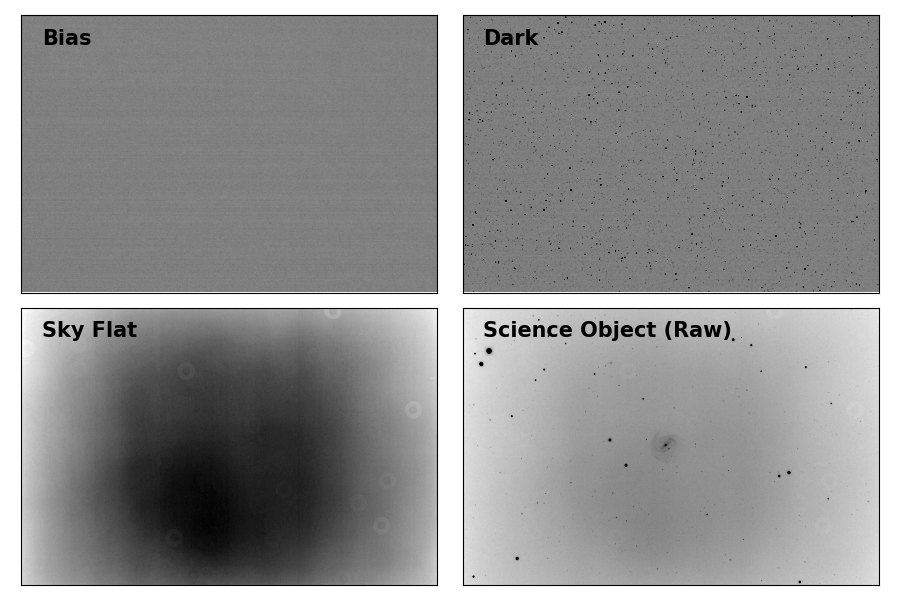

In [8]:
bias0 = fits.getdata(bias_list[0])
dark0 = fits.getdata(dark_list[0])
flat0 = fits.getdata(flat_list[0])
sci0  = fits.getdata(sci_list[0])
label = ["Bias", "Dark", "Sky Flat", "Science Object (Raw)"]

from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

fig, axs = plt.subplots(2, 2, figsize=(9,6))
for i, img0 in enumerate([bias0, dark0, flat0, sci0]):
    vmin, vmax = interval.get_limits(img0)
    ax = axs[i // 2][i % 2]
    ax.imshow(img0, cmap='gray_r', origin='lower', vmin=vmin, vmax=vmax)
    ax.tick_params(axis='both', length=0.0, labelleft=False, labelbottom=False)
    ax.text(0.05, 0.95, label[i], fontsize=15.0, fontweight='bold',
            transform=ax.transAxes, ha='left', va='top')
plt.tight_layout()

In [9]:
ds9_options = "-scalemode zscale -scale lock yes -frame lock image -tile grid mode manual -tile grid layout 4 1"
os.system("ds9 "+bias_list[0]+" "+dark_list[0]+" "+flat_list[0]+" "+sci_list[0]+" "+ds9_options+" &")

0

# 2. Combining the Frames

### Creating a Master Bias